In [16]:
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
# -*- coding: utf-8 -*-
"""
Production runner with Historical vs Closed-Loop modes.

What it does (idempotent):
  1) Ensures ML predictions for the 6-month lookback + today's stamps → CSV cache
  2) Ensures GP residual rows for the 6-month window → Pickle cache
  3) Fits GP on the 6-month slice
  4) (Per stamp) Auto-tunes per-product α by slope fidelity (rc0-injected), saves fidelity
  5) Runs multi-knob RCOT optimizer (with anchored objective), prints/saves RCOT moves, price audit
  6) Saves curves (overrides-only α, rc0-injected) + per-geometry fidelity audit
  7) At the end: builds a counterfactual schedule and simulates corrected yields + margin
     (consistent end-of-run check; for online closed-loop the state is updated in-loop)

Supports modes:
  - historical
  - closed_loop: apply recommended RCOTs on a stateful copy of X and hold until next decision.
    Keeps caches separate via a cache_tag to avoid polluting historical ones.
"""

from __future__ import annotations
import json
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, Sequence, List, Optional, Tuple, Any
import numpy as np
import pandas as pd
from src.ml_predictor import MLPredictor, MLPredictorConfig

import warnings
warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names",
    category=UserWarning,
    module="sklearn"
)

# ---- project imports ----
from importlib import reload
import src.gp_residuals as gpmod
import src.optimizer    as opt


# =================== CONFIG (static) ===================
LOOKBACK_6M    = pd.Timedelta(days=180)
MIN_TR_ROWS    = 180
GP_JOBS        = 8

START          = pd.Timestamp('2025-01-01')
END            = pd.Timestamp('2025-09-15')

OUT_DIR        = Path("prod_out")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Base OUT dir; mode-specific subdirs will be derived
OUT_DIR_BASE   = Path("prod_out")
OUT_DIR_BASE.mkdir(parents=True, exist_ok=True)

# RCOT bounds (single source of truth)
RC_BOUNDS = {
    'LF_NAPH':     (830.0, 853.0),
    'GF_GAS':      (860.0, 890.0),
    'GF_HYB_NAPH': (830.0, 853.0),
}

# canonical products
PRODS_CANON = ("Ethylene","Propylene","Mixed C4","RPG","Hydrogen","Tail Gas")
# canonical internal keys for corrected_yields_for_row
PRODS_INTERNAL = ['Ethylene','Propylene','MixedC4','RPG','Ethane','Propane','Hydrogen','Tail_Gas']
TARGET_COLS = [f'{p}_prod_t+1' for p in PRODS_INTERNAL]

# =================== HELPERS ===================
def _ts_per_day(index: pd.DatetimeIndex, day: pd.Timestamp) -> List[pd.Timestamp]:
    d0 = pd.Timestamp(day).normalize()
    d1 = d0 + pd.Timedelta(days=1)
    idx = index[(index >= d0) & (index < d1)]
    return list(idx)

def _safe_merge_csv(path: Path, df_new: pd.DataFrame, key: str | list[str] = 'timestamp') -> pd.DataFrame:
    key_cols = [key] if isinstance(key, str) else list(key)
    if path.exists():
        old = pd.read_csv(path, parse_dates=[k for k in key_cols if 'time' in k.lower()])
        old = old.set_index(key_cols).sort_index()
    else:
        if len(key_cols) == 1:
            k = key_cols[0]
            idx = (pd.DatetimeIndex([], name=k) if 'time' in k.lower() else pd.Index([], name=k))
            old = pd.DataFrame(index=idx)
        else:
            idx = pd.MultiIndex.from_arrays([[] for _ in key_cols], names=key_cols)
            old = pd.DataFrame(index=idx)

    new = df_new.copy()
    for k in key_cols:
        if k in new.columns and 'time' in k.lower():
            new[k] = pd.to_datetime(new[k], errors='coerce')
    new = new.set_index(key_cols).sort_index()

    out = pd.concat([old[~old.index.isin(new.index)], new], axis=0).sort_index()
    out_reset = out.reset_index()
    out_reset.to_csv(path, index=False)
    return out_reset

def _safe_merge_pickle(path: Path, df_new: pd.DataFrame, min_index: pd.Timestamp | None = None) -> pd.DataFrame:
    if path.exists():
        old = pd.read_pickle(path)
        old.index = pd.to_datetime(old.index)
    else:
        old = pd.DataFrame()

    if df_new is not None and len(df_new):
        df_new = df_new.copy()
        df_new.index = pd.to_datetime(df_new.index)
        out = pd.concat([old, df_new], axis=0)
    else:
        out = old

    if min_index is not None and not out.empty:
        out = out.loc[out.index >= pd.Timestamp(min_index)]

    out = out[~out.index.duplicated(keep='last')].sort_index()
    out.to_pickle(path)
    return out

def realized_margin_from_Y(ts: pd.Timestamp, x_row: pd.Series, Y_12h: pd.DataFrame, margin_fn) -> float:
    ydict = {}
    for p in PRODS_INTERNAL:
        col = f"{p}_prod_t+1"
        ydict[col] = float(Y_12h.at[ts, col]) if (ts in Y_12h.index and col in Y_12h.columns) else 0.0
    return float(margin_fn(ts, x_row, ydict))

def _geometry_label_for_row(row: pd.Series) -> str:
    n = sum(row.get(f'Naphtha_chamber{i}', 0.0) for i in range(1,7))
    g = sum(row.get(f'Gas Feed_chamber{i}', 0.0) for i in (4,5,6))
    if n>0 and g>0: return 'GF_HYB_NAPH'
    if n>0:         return 'LF_NAPH'
    if g>0:         return 'GF_GAS'
    return 'NONE'

def _norm_geom(g: str) -> str:
    return str(g).strip().replace(" ","_").upper()

def _bounds_for_geoms() -> dict[str, tuple[float,float]]:
    return {'LF_NAPH':(800.0,895.0), 'GF_GAS':(820.0,910.0), 'GF_HYB_NAPH':(800.0,895.0)}

def _rc_grid_for(ts_row: pd.Series, geom: str, lo: float, hi: float, points: int=15) -> np.ndarray:
    rc0 = gpmod.rc0_guess_for_geom(ts_row, geom, fallback_rc=None)
    base = np.linspace(lo, hi, points)
    return np.unique(np.r_[base, rc0]) if rc0 is not None else base

# =================== ML CACHE ADAPTER ===================
class MLCacheAdapter:
    """Adapter for cached ML predictions; provides transform() (no-op) and predict_row()."""
    def __init__(self, pred_df: pd.DataFrame):
        self.pred_df = pred_df

    def transform(self, X_12h: pd.DataFrame, Y_12h: pd.DataFrame):
        # interface compliance; not used by GP table
        return X_12h

    def predict_row(self, row_like, **kwargs):
        ts = getattr(row_like, 'name', None)
        if ts is None or ts not in self.pred_df.index:
            return {}
        s = self.pred_df.loc[ts]
        return {c: float(s.get(c, np.nan)) for c in self.pred_df.columns}

# =================== FIDELITY (slope-only gate) ===================
def _robust_slope_metrics(curve: pd.DataFrame, prod: str) -> tuple[float,float]:
    if curve is None or curve.empty or len(curve) < 3:
        return (np.nan, 0.0)
    s = curve.get(f'{prod}_SRTO_tph'); c = curve.get(f'{prod}_CORR_tph')
    if s is None or c is None: return (np.nan, 0.0)
    s = s.to_numpy(float); c = c.to_numpy(float)
    ds, dc = np.diff(s), np.diff(c)
    ds_f = ds[np.isfinite(ds)]
    if ds_f.size == 0: return (np.nan, 0.0)
    eps  = 0.01*(np.nanpercentile(np.abs(ds_f),95) + 1e-12)
    mask = np.abs(ds) >= eps
    if mask.sum() < 3 or not np.isfinite(dc[mask]).all(): return (np.nan, float(mask.mean()))
    return (float(np.corrcoef(ds[mask], dc[mask])[0,1]), float(mask.mean()))

def _rcot_setter_single_knob(knob: str):
    def _setter(row_like: pd.Series, rc: float) -> pd.Series:
        row_like[knob] = float(rc)
        return row_like
    return _setter

def _local_rc_grid(rc0: float, lo: float, hi: float, halfspan: float = 10.0, n: int = 9) -> np.ndarray:
    if not np.isfinite(rc0):
        return np.linspace(lo, hi, n)
    a, b = max(lo, rc0 - halfspan), min(hi, rc0 + halfspan)
    return np.unique(np.r_[np.linspace(a, b, n), rc0])

def _knob_from_leg(leg: dict) -> str:
    ch = leg['chamber']
    if leg['feed'] == 'gas':
        return f'RCOT_gas_chamber{ch}'
    if ch in (1,2,3):
        return f'RCOT_chamber{ch}'
    return f'RCOT_naphtha_chamber{ch}'

def build_knob_fidelity_gate(*, ts, row_current, gp, X_12h, merged_lims, pipeline, ml_cached,
                             rc_bounds_map, thr_corr=0.92, min_cov=0.20,
                             halfspan_ok=10.0, halfspan_fallback=2.0):
    """
    Returns: (bounds_by_knob: dict, knob_fid_df: DataFrame)
      PASS → trust ±halfspan_ok (clipped to geometry bounds)
      FAIL → try SRTO finite-difference fallback; if OK → ±halfspan_fallback; else FREEZE (rc0,rc0)
    """
    comp_row = gp._comp_row_for_ts(merged_lims, ts)
    legs = pipeline._chamber_legs_from_state(row_current, feed_thr=1.0)  # active legs only

    rows, bounds_by_knob = [], {}
    KEY = ['Ethylene','Propylene','RPG']  # key revenue drivers

    for leg in legs:
        geom = leg['geometry']  # 'LF_NAPH' | 'GF_GAS' | 'GF_HYB_NAPH'
        knob = _knob_from_leg(leg)
        rc0  = float(row_current.get(knob, np.nan))
        lo, hi = rc_bounds_map.get(geom, (800.0, 895.0))
        rc_grid = _local_rc_grid(rc0, lo, hi, halfspan=halfspan_ok, n=9)

        # Local anchored curve with tuned α (already set on gp)
        curve, _ = gpmod.anchored_curve_at_ts(
            gp=gp, X_12h=X_12h, merged_lims=merged_lims, pipeline=pipeline, ml=ml_cached,
            ts=ts, rcot_setter=_rcot_setter_single_knob(knob), rc_grid=rc_grid,
            use_gp_delta=True, alpha=0.0
        )

        flags = []
        for p in KEY:
            sc, cov = _robust_slope_metrics(curve, p)
            rows.append({'timestamp': ts, 'geometry': geom, 'chamber': leg['chamber'],
                         'knob': knob, 'product': p, 'slope_corr': sc, 'sign_cov': cov})
            flags.append((sc >= thr_corr) and (cov >= min_cov))

        if all(flags):
            a = max(lo, rc0 - halfspan_ok); b = min(hi, rc0 + halfspan_ok)
            bounds_by_knob[knob] = (a, b)
            continue

        # Fallback: SRTO central difference at rc0 ± 5°C
        try:
            dC = 5.0
            def _spot(rc):
                r = row_current.copy(); r[knob] = float(np.clip(rc, lo, hi))
                spot = pipeline.predict_spot_plant(r, comp_row, feed_thr=0.1)
                return spot['totals_tph'] if spot.get('status') == 'ok' else {}
            y_lo = _spot(rc0 - dC); y_hi = _spot(rc0 + dC)
            fd_ok = all(abs(y_hi.get(k,0.0) - y_lo.get(k,0.0)) > 1e-6 for k in KEY)
        except Exception:
            fd_ok = False

        if fd_ok:
            a = max(lo, rc0 - halfspan_fallback); b = min(hi, rc0 + halfspan_fallback)
            bounds_by_knob[knob] = (a, b)
        else:
            bounds_by_knob[knob] = (rc0, rc0)

    return bounds_by_knob, pd.DataFrame(rows)


def auto_alpha_until_pass_for_ts(
    gp: gpmod.GPResiduals,
    ts: pd.Timestamp,
    row0: pd.Series,
    X_12h: pd.DataFrame,
    merged_lims: pd.DataFrame,
    pipeline,
    ml_cached,
    thr_corr: float=0.92,
    min_cov: float=0.20,
    rc_points: int=15
) -> tuple[dict, pd.DataFrame, pd.DataFrame]:

    geoms = []
    n = sum(float(row0.get(f'Naphtha_chamber{i}',0.0)) for i in range(1,7))
    g = sum(float(row0.get(f'Gas Feed_chamber{i}',0.0)) for i in (4,5,6))
    if n > 1.0: geoms.append('LF_NAPH')
    if g > 1.0: geoms.append('GF_GAS')
    if n > 1.0 and g > 1.0: geoms.append('GF_HYB_NAPH')

    setter_map = {'LF_NAPH':gpmod.rcot_setter_lf_naph, 'GF_GAS':gpmod.rcot_setter_gf_gas, 'GF_HYB_NAPH':gpmod.rcot_setter_hybrid}
    rc_bounds  = _bounds_for_geoms()
    setter_map = {g:setter_map[g] for g in geoms}; rc_bounds = {g:rc_bounds[g] for g in geoms}

    overrides: dict[tuple[str,str], float] = {}
    alpha_grid = np.r_[np.linspace(0.35, 0.0, 8), 0.0]

    # First pass: find failing pairs
    gp.set_alpha_overrides({})
    fid_rows = []
    for g in geoms:
        lo, hi = rc_bounds[g]; rc_grid = _rc_grid_for(row0, g, lo, hi, points=rc_points)
        curve, _ = gpmod.anchored_curve_at_ts(
            gp=gp, X_12h=X_12h, merged_lims=merged_lims, pipeline=pipeline,
            ml=ml_cached, ts=ts, rcot_setter=setter_map[g], rc_grid=rc_grid,
            use_gp_delta=True, alpha=0.0
        )
        for p in gpmod.PRODUCTS:
            sc, cov = _robust_slope_metrics(curve, p)
            fid_rows.append({'timestamp': ts, 'geometry': _norm_geom(g), 'product': p, 'slope_corr': sc, 'sign_cov': cov})
    fid0 = pd.DataFrame(fid_rows)
    fails = fid0.loc[(fid0['slope_corr'] < thr_corr) | (fid0['sign_cov'] < min_cov), ['product','geometry']].drop_duplicates()

    # Iterate α for failing pairs
    for prod, geom in fails.itertuples(index=False):
        tcol = gpmod.TARGET_MAP[prod]
        best = None
        for a in alpha_grid:
            trial = {**overrides, (_norm_geom(geom), tcol): float(a)}
            gp.set_alpha_overrides(trial)
            lo, hi = rc_bounds[geom]; rc_grid = _rc_grid_for(row0, geom, lo, hi, points=rc_points)
            curve, _ = gpmod.anchored_curve_at_ts(
                gp=gp, X_12h=X_12h, merged_lims=merged_lims, pipeline=pipeline,
                ml=ml_cached, ts=ts, rcot_setter=setter_map[geom], rc_grid=rc_grid,
                use_gp_delta=True, alpha=0.0
            )
            sc, cov = _robust_slope_metrics(curve, prod)
            if sc >= thr_corr and cov >= min_cov:
                best = float(a); break
        overrides[(_norm_geom(geom), tcol)] = (0.0 if best is None else best)

    # Final detail/summary with overrides
    gp.set_alpha_overrides(overrides)
    fid_rows = []
    for g in geoms:
        lo, hi = rc_bounds[g]; rc_grid = _rc_grid_for(row0, g, lo, hi, points=rc_points)
        curve, _ = gpmod.anchored_curve_at_ts(
            gp=gp, X_12h=X_12h, merged_lims=merged_lims, pipeline=pipeline,
            ml=ml_cached, ts=ts, rcot_setter=setter_map[g], rc_grid=rc_grid,
            use_gp_delta=True, alpha=0.0
        )
        for p in gpmod.PRODUCTS:
            sc, cov = _robust_slope_metrics(curve, p)
            a_col, c_col = f'{p}_ANCHOR_tph', f'{p}_CORR_tph'
            diff = (curve[c_col].astype(float) - curve[a_col].astype(float)).abs().to_numpy(float) if (a_col in curve and c_col in curve) else np.array([np.nan])
            am_min = float(np.nanmin(diff))
            fid_rows.append({'timestamp': ts, 'geometry': _norm_geom(g), 'product': p,
                             'slope_corr': sc, 'sign_cov': cov, 'anchor_miss_min': am_min})
    fid = pd.DataFrame(fid_rows)
    fid['slope_ok'] = (fid['slope_corr'] >= thr_corr) & (fid['sign_cov'] >= min_cov)
    summ = (fid.groupby(['product','geometry'])['slope_ok']
                .agg(pct_ok=lambda s: float(100.0*s.mean()), n='count')
                .reset_index()
                .sort_values(['product','geometry']))
    return overrides, fid, summ

# =================== Counterfactual schedule & simulate ===================
def build_rcot_schedule_from_recs(rec_df: pd.DataFrame) -> list[tuple[pd.Timestamp, dict]]:
    if 'timestamp' in rec_df.columns:
        df = rec_df.set_index('timestamp')
    else:
        df = rec_df.copy()
    df = df.sort_index()
    knobs_cols = [c for c in df.columns if c.startswith('rcot_opt_')]
    sched = []
    for ts, r in df.iterrows():
        setpoints = {}
        for c in knobs_cols:
            v = r.get(c, np.nan)
            if pd.notna(v):
                knob = c.replace('rcot_opt_', '')
                setpoints[knob] = float(v)
        if setpoints:
            sched.append((pd.Timestamp(ts), setpoints))
    return sched

def apply_schedule_to_X(X_12h: pd.DataFrame, schedule: list[tuple[pd.Timestamp, dict]],
                        start: pd.Timestamp | None = None,
                        end:   pd.Timestamp | None = None,
                        hold: str = "hold_until_next") -> pd.DataFrame:
    X_sim = X_12h.copy(); idx = X_sim.index
    if start is None: start = idx.min()
    if end   is None: end   = idx.max()
    schedule = sorted([(pd.Timestamp(t), d) for (t,d) in schedule if start <= pd.Timestamp(t) <= end],
                      key=lambda x: x[0])
    if not schedule:
        return X_sim
    schedule2 = schedule + [(pd.Timestamp(end) + pd.Timedelta(seconds=1), {})]
    for (t0, setpoints), (t1, _) in zip(schedule2[:-1], schedule2[1:]):
        mask = (idx >= t0) & (idx < t1)
        if not mask.any(): continue
        for knob, val in setpoints.items():
            if knob in X_sim.columns:
                X_sim.loc[mask, knob] = float(val)
    return X_sim

def simulate_path_corrected(X_sim: pd.DataFrame,
                            merged_lims: pd.DataFrame,
                            pipeline,
                            gp: gpmod.GPResiduals,
                            gps_dict: dict,
                            feature_cols_gp: list[str],
                            price_provider: opt.PriceProvider,
                            total_spyro_yield_for_now,
                            fg_consts: opt.FuelGasConstants,
                            alpha_overrides: dict | None = None,
                            start: pd.Timestamp | None = None,
                            end:   pd.Timestamp | None = None) -> tuple[pd.DataFrame, pd.DataFrame]:
    idx = X_sim.index
    if start is None: start = idx.min()
    if end   is None: end   = idx.max()
    stamps = idx[(idx >= start) & (idx <= end)]

    margin_fn = opt.make_margin_fn_excel_delta(price_provider=price_provider,
                                               total_spyro_yield_for_now=total_spyro_yield_for_now,
                                               spyro_ctx=None, fg_constants=fg_consts)

    Y_rows, M_rows = [], []
    for ts in stamps:
        row = X_sim.loc[ts].copy(); row.name = ts
        y   = opt.corrected_yields_for_row(row, gps_dict, feature_cols_gp,
                                           total_spyro_yield_for_now, spyro_ctx=None,
                                           alpha_overrides=alpha_overrides)
        Y_rows.append({'timestamp': ts, **y})
        M_rows.append({'timestamp': ts, 'margin_per_h': float(margin_fn(ts, row, y))})

    Y_sim = pd.DataFrame(Y_rows).set_index('timestamp').sort_index()
    M_sim = pd.DataFrame(M_rows).set_index('timestamp').sort_index()
    return Y_sim, M_sim

def _cache_path(prefix: str, cache_tag: str, mode: str, train_mode: str, ext: str) -> Path:
    tag = cache_tag or ""
    return OUT_DIR / f"{prefix}{tag}_{mode}_{train_mode}.{ext}"

def effective_target_cols(Y_12h: pd.DataFrame, explicit: Optional[Sequence[str]] = None) -> List[str]:
    from_cols = [c for c in Y_12h.columns if c.endswith("_prod_t+1")]
    if explicit is None:
        return sorted(set(from_cols))
    return sorted(set(explicit) | set(from_cols))

def seed_sim_state(Y_12h: pd.DataFrame, tcols: Sequence[str], seed_until: pd.Timestamp) -> pd.DataFrame:
    ys = pd.DataFrame(index=Y_12h.index, columns=list(tcols), dtype=float)
    common = [c for c in tcols if c in Y_12h.columns]
    ys.loc[:, common] = Y_12h[common]
    ys.loc[ys.index > seed_until, :] = np.nan
    return ys

def ensure_ml_preds_for(
    stamps: Sequence[pd.Timestamp],
    Xsrc: pd.DataFrame,
    Ysrc: pd.DataFrame,
    lookback: pd.Timedelta,
    target_cols: Sequence[str],
    *,
    mode: str,                 # 'historical' | 'closed_loop'
    train_mode: str,           # 'historical' | 'simulated'
    cache_tag: str = "",
    gp=None,
    gps_dict=None,
    feature_cols_gp = None,
    Y_sim_state: Optional[pd.DataFrame] = None,
) -> pd.DataFrame:
    """
    Predict ML targets for `stamps`, keeping a cache per (mode, train_mode, cache_tag).
    - train_mode=historical  → fit on Ysrc (ground truth)
    - train_mode=simulated   → fit on Y_sim_state (simulated truth)
    - Lags always read from (Y_sim_state ⊕ Ysrc) during closed-loop to avoid KeyErrors.
    """
    cache_csv = _cache_path("ml_cache", cache_tag, mode, train_mode, "csv")
    if cache_csv.exists():
        pred_cache = pd.read_csv(cache_csv, parse_dates=["timestamp"]).set_index("timestamp")
    else:
        pred_cache = pd.DataFrame(index=pd.DatetimeIndex([], name="timestamp"))

    missing = sorted(ts for ts in stamps if ts not in pred_cache.index)
    if not missing:
        return pred_cache

    rows = []
    tcols = list(target_cols)

    for ts in missing:
        ts_start = ts - lookback
        tr = Xsrc.index[(Xsrc.index >= ts_start) & (Xsrc.index < ts)]
        if len(tr) < MIN_TR_ROWS:
            # not enough history to fit
            rows.append({"timestamp": ts, **{c: np.nan for c in tcols}})
            continue

        Y_train = (Y_sim_state if (train_mode == "simulated" and Y_sim_state is not None) else Ysrc)

        ml = MLPredictor(
            target_cols=tcols,
            cfg=MLPredictorConfig(
                ds_prefixes=["DS_chamber"],
                add_virtual_rcots=True,
                build_lag1_from_targets=True,
                lgbm_params=dict(verbosity=-1, n_jobs=2),
            ),
        ).fit(Xsrc.loc[tr], Y_train.loc[tr])

        # choose lag source (combine so missing columns are tolerated)
        if mode == "closed_loop" and Y_sim_state is not None:
            Y_lag_src = Y_sim_state.combine_first(Ysrc)
        else:
            Y_lag_src = Ysrc

        pm = ml.predict_row(Xsrc.loc[ts], Y_for_lags=Y_lag_src)
        rows.append({"timestamp": ts, **{c: float(pm.get(c, np.nan)) for c in tcols}})

    if rows:
        add_df = pd.DataFrame(rows).set_index("timestamp")
        pred_cache = pd.concat([pred_cache, add_df], axis=0).sort_index()
        pred_cache.to_csv(cache_csv, index=True)

    return pred_cache

def _legs_to_df(legs: list[dict]) -> pd.DataFrame:
    rows = []
    keep = ['Ethylene','Propylene','MixedC4','RPG','PFO','Ethane','Propane','Tail_Gas','Hydrogen']
    for lg in legs:
        rec = {
            'chamber': lg.get('chamber'),
            'feed': lg.get('feed'),
            'geometry': lg.get('geometry'),
            'rcot_used': float(lg.get('rcot_used', np.nan)),
            'feed_tph': float(lg.get('feed_tph', 0.0)),
            'IRET': float(lg.get('IRET', np.nan))
        }
        for k in keep:
            rec[f'{k}_tph'] = float(lg.get('tph', {}).get(k, 0.0))
        rows.append(rec)
    return pd.DataFrame(rows)

def _ch_from_knob(knob: str) -> int | None:
    if knob.startswith('RCOT_chamber'):            return int(knob.replace('RCOT_chamber',''))
    if knob.startswith('RCOT_naphtha_chamber'):    return int(knob.replace('RCOT_naphtha_chamber',''))
    if knob.startswith('RCOT_gas_chamber'):        return int(knob.replace('RCOT_gas_chamber',''))
    return None

# =================== RUNNER ===================
def run_production(X_12h: pd.DataFrame, Y_12h: pd.DataFrame,
                   merged_lims: pd.DataFrame, pipeline,
                   prices_df: pd.DataFrame,
                   total_spyro_yield_for_now,
                   start: pd.Timestamp,
                   end:   pd.Timestamp | None = None,
                   mode: str = 'historical',
                   closed_loop_opts: dict | None = None):
    """
    mode:
      - 'historical': baseline behavior
      - 'closed_loop': step & hold recommended RCOTs on a stateful copy of X;
                       uses simulated lags for ML/inference; separate caches via cache_tag.
    """
    assert mode in ('historical','closed_loop')
    closed_loop_opts = closed_loop_opts or {}
    apply_timing  = closed_loop_opts.get('apply_timing', 'next_day')
    hold_policy   = closed_loop_opts.get('hold_policy',  'hold_until_next')
    ml_train_mode = closed_loop_opts.get('ml_train_mode','historical')
    gp_train_mode = closed_loop_opts.get('gp_train_mode','historical')
    cache_tag     = closed_loop_opts.get('cache_tag',    '' if mode=='historical' else '_sim')

    # Out dirs & caches
    OUT_DIR = OUT_DIR_BASE / (('closed_loop' + cache_tag) if mode=='closed_loop' else 'historical')
    OUT_DIR.mkdir(parents=True, exist_ok=True)
    CURVES_DIR = OUT_DIR / "curves"; CURVES_DIR.mkdir(parents=True, exist_ok=True)
    FID_DIR    = OUT_DIR / "fidelity"; FID_DIR.mkdir(parents=True, exist_ok=True)
    MOV_DIR    = OUT_DIR / "rcot_moves"; MOV_DIR.mkdir(parents=True, exist_ok=True)
    AK_DIR     = OUT_DIR / "active_knobs"; AK_DIR.mkdir(parents=True, exist_ok=True)
    AUD_DIR    = OUT_DIR / "audits"; AUD_DIR.mkdir(parents=True, exist_ok=True)
    SNAP_DIR   = OUT_DIR / "multi_snapshots"; SNAP_DIR.mkdir(parents=True, exist_ok=True)
    CF_DIR     = OUT_DIR / "counterfactual"; CF_DIR.mkdir(parents=True, exist_ok=True)
    KNOB_FID_DIR = FID_DIR / "knob"; KNOB_FID_DIR.mkdir(parents=True, exist_ok=True)
    ATTR_DIR   = OUT_DIR / "attribution"; ATTR_DIR.mkdir(parents=True, exist_ok=True)

    pp = opt.PriceProvider(prices_df)
    gpmod.set_rcot_groups_from_columns(X_12h.columns)

    # fuel-gas constants
    fg_consts = opt.FuelGasConstants(
        rc_ref_naph=840.0, rc_ref_gas=880.0,
        cp_wavg_kcal_per_ton_K=411.488209,
        dH_eth_kcal_per_ton=1_080_970.0,
        dH_prop_kcal_per_ton=673_409.0,
        dH_fg_kcal_per_ton=926_147.0,
        fuel_gas_heat_content_kcal_per_ton=15_294_088.0
    )

    idx_all = X_12h.index.sort_values()
    if end is None: end = idx_all.max().normalize()

    # Closed-loop state
    X_state = X_12h.copy()
    tcols_for_sim = [c for c in TARGET_COLS if c in Y_12h.columns]
    Y_sim_state = (Y_12h.reindex(columns=tcols_for_sim).copy() if mode=='closed_loop' else None)

    # ---------- GP training cache helper ----------
    def ensure_gp_train_for_window(train_start: pd.Timestamp, train_end: pd.Timestamp,
                                   Xs: pd.DataFrame, Ys: pd.DataFrame,
                                   merged_lims: pd.DataFrame, pipeline,
                                   ml_cached: MLCacheAdapter) -> pd.DataFrame:
        if (OUT_DIR / f"gp_train_cache{cache_tag}.pkl").exists():
            gp_cache = pd.read_pickle(OUT_DIR / f"gp_train_cache{cache_tag}.pkl")
            gp_cache.index = pd.to_datetime(gp_cache.index)
            cached_idx = gp_cache.index
        else:
            gp_cache = pd.DataFrame(); cached_idx = pd.DatetimeIndex([])

        idx_in_win = Xs.index[(Xs.index >= train_start) & (Xs.index <= train_end)]
        need = [ts for ts in idx_in_win if ts not in cached_idx]
        if need:
            s = min(need); e = max(need)
            Xsrc = (X_state if (mode=='closed_loop' and gp_train_mode=='simulated') else Xs)
            Ysrc = (Y_sim_state if (mode=='closed_loop' and Y_sim_state is not None and gp_train_mode=='simulated') else Ys)
            df_new = gpmod.GPResiduals.build_training_table(
                Xsrc, Ysrc, merged_lims, pipeline,
                start=s, end=e, feed_thr=0.1,
                feature_cfg=gpmod.GPFeatureConfig(
                    ds_prefixes=['DS_chamber'], rcot_prefixes=['RCOT_'],
                    feed_prefixes=['Naphtha_chamber','Gas Feed_chamber'],
                    include_ratio_naphtha=True, include_geometry_flags=True
                ),
                residual_kind='ml', ml=ml_cached
            )
            if not df_new.empty:
                df_new.index = pd.to_datetime(df_new.index)
                _safe_merge_pickle(OUT_DIR / f"gp_train_cache{cache_tag}.pkl", df_new, min_index=train_start)
        if (OUT_DIR / f"gp_train_cache{cache_tag}.pkl").exists():
            win = pd.read_pickle(OUT_DIR / f"gp_train_cache{cache_tag}.pkl")
            win.index = pd.to_datetime(win.index)
            win = win.loc[(win.index >= train_start) & (win.index <= train_end)].sort_index()
        else:
            win = pd.DataFrame()
        return win

    # ===== daily loop =====
    for day in pd.date_range(pd.Timestamp(start).normalize(), pd.Timestamp(end).normalize(), freq='D'):
        stamps = _ts_per_day(idx_all, day)
        if not stamps:
            continue
        te = stamps[-1] - pd.Timedelta(hours=12)
        ts_train_start = te - LOOKBACK_6M

        # ---- ML cache for the training window (respect provenance) ----
        tcols_ml = [c for c in TARGET_COLS if c in Y_12h.columns]
        Xsrc_train = X_state if (mode=='closed_loop' and ml_train_mode=='simulated') else X_12h
        train_stamps = list(X_12h.index[(X_12h.index >= ts_train_start) & (X_12h.index <= te)])
        pred_cache_train = ensure_ml_preds_for(
            train_stamps, Xsrc_train, Y_12h, lookback=LOOKBACK_6M, target_cols=tcols_ml,
            mode=mode, train_mode=ml_train_mode, cache_tag=cache_tag,
            Y_sim_state=(Y_sim_state if mode == 'closed_loop' else None),
        )
        ml_cached_train = MLCacheAdapter(pred_cache_train)

        # ---- GP train cache ----
        df_train_win = ensure_gp_train_for_window(ts_train_start, te, X_12h, Y_12h, merged_lims, pipeline, ml_cached_train)
        if df_train_win.empty:
            continue

        gp = gpmod.GPResiduals(
            feature_cfg=gpmod.GPFeatureConfig(
                ds_prefixes=['DS_chamber'], rcot_prefixes=['RCOT_'],
                feed_prefixes=['Naphtha_chamber','Gas Feed_chamber'],
                include_ratio_naphtha=True, include_geometry_flags=True
            ),
            n_restarts=2, normalize_y=True
        ).fit_parallel(df_train_win, n_jobs=GP_JOBS)

        gps_dict = {f'{p}_prod_t+1': gp.models_[p] for p in gpmod.PRODUCTS if p in gp.models_}
        feature_cols_gp = gp.feature_names_

        rec_rows = []
        for ts in stamps:
            # ---- current row from state ----
            row_current = (X_state if mode=='closed_loop' else X_12h).loc[ts].copy(); row_current.name = ts

            # ensure Spyro sees a timestamp
            def _spyro_ts(row_like, short_key, ctx=None, _ts=ts):
                r = row_like
                if getattr(r, 'name', None) is None:
                    r = r.copy(); r.name = _ts
                return total_spyro_yield_for_now(r, short_key, ctx)

            geom = _geometry_label_for_row(row_current)
            naph_b, gas_b = RC_BOUNDS.get('LF_NAPH'), RC_BOUNDS.get('GF_GAS')

            margin_fn = opt.make_margin_fn_excel_delta(
                price_provider=pp,
                total_spyro_yield_for_now=_spyro_ts,
                spyro_ctx=None,
                fg_constants=fg_consts
            )

            # ---- spot ML baseline using UPDATED state ----
            pred_cache_spot = ensure_ml_preds_for(
                [ts], (X_state if mode=='closed_loop' else X_12h), Y_12h,
                lookback=LOOKBACK_6M, target_cols=tcols_ml,
                mode=mode, train_mode=ml_train_mode, cache_tag=cache_tag,
                Y_sim_state=(Y_sim_state if mode == 'closed_loop' else None),
            )
            ml_cached = MLCacheAdapter(pred_cache_spot)
            y0 = ml_cached.predict_row(row_current)
            m0 = margin_fn(ts, row_current, y0)
            m_real = realized_margin_from_Y(ts, row_current, Y_12h, margin_fn)

            # ---- fidelity + knob gate ----
            overrides, fid_detail, fid_summary = auto_alpha_until_pass_for_ts(
                gp=gp, ts=ts, row0=row_current, X_12h=X_12h,
                merged_lims=merged_lims, pipeline=pipeline, ml_cached=ml_cached,
                thr_corr=0.92, min_cov=0.20, rc_points=15
            )
            FID_DIR.mkdir(exist_ok=True, parents=True)
            fid_detail.to_csv((OUT_DIR / "fidelity" / f"fidelity_detail_{ts:%Y%m%d_%H%M}.csv"), index=False)
            fid_summary.to_csv((OUT_DIR / "fidelity" / f"fidelity_summary_{ts:%Y%m%d_%H%M}.csv"), index=False)

            bounds_by_knob, knob_fid = build_knob_fidelity_gate(
                ts=ts, row_current=row_current, gp=gp,
                X_12h=X_12h, merged_lims=merged_lims, pipeline=pipeline, ml_cached=ml_cached,
                rc_bounds_map=RC_BOUNDS, thr_corr=0.92, min_cov=0.20,
                halfspan_ok=10.0, halfspan_fallback=2.0
            )
            (OUT_DIR / "fidelity" / "knob").mkdir(exist_ok=True, parents=True)
            knob_fid.to_csv(OUT_DIR / "fidelity" / "knob" / f"fidelity_knob_{ts:%Y%m%d_%H%M}.csv", index=False)

            # ---- Optimize (anchored objective) ----
            res = opt.optimize_rcot_for_ts_multi(
                ts=ts, row0=row_current,
                gps=gps_dict, feature_cols_gp=feature_cols_gp,
                total_spyro_yield_for_now=total_spyro_yield_for_now, spyro_ctx=None,
                price_provider=pp,
                objective='per_hour',
                naph_bounds=naph_b, gas_bounds=gas_b,
                trust_delta_C=5.0,                     # your ±5 °C trust window
                use_recycle_fixed_point=False, recycle_fn=None,
                margin_mode='excel_delta', fg_constants=fg_consts,
                alpha_overrides=None,
                enable_de=True, enable_slsqp=True,
                bounds_by_knob=bounds_by_knob,
                anchored_from_ml=True,                 # ← anchored mode
                gp=gp, pipeline=pipeline, merged_lims=merged_lims, ml_cached=ml_cached,
                alpha_default_for_anchor=0.0
            )

            row_opt = res['row_opt']; y_opt = res['yields_opt']
            m_base  = res['margin_current_per_h']; m_opt = res['margin_opt_per_h']; d_m = res['improvement_per_h']

            print("\n=== MULTI-KNOB RESULT ===")
            print("Status:", res.get('status'))
            print("ΔMargin $/h:", f"{d_m:,.2f}")
            print("RCOT* (per chamber):")
            for k,v in res['rcot_opt'].items():
                cur = float(row_current.get(k, np.nan))
                print(f"  {k:24s}  {cur:7.2f} → {float(v):7.2f}  (Δ {float(v)-cur:+.2f})")

            # ---- Flat record ----
            flat = {
                'timestamp': ts, 'geometry': geom, 'status': res['status'],
                'margin_baseline_per_h': float(m0),
                'margin_opt_per_h':      float(m_opt),
                'improvement_per_h':     float(d_m),
                'margin_realized_per_h': float(m_real),
                'margin_current_per_h':  float(m_base),
            }
            rcot_cols = [f'RCOT_chamber{i}' for i in (1,2,3)] \
                      + [f'RCOT_naphtha_chamber{i}' for i in (4,5,6)] \
                      + [f'RCOT_gas_chamber{i}'     for i in (4,5,6)]
            for c in rcot_cols:
                flat[f'rcot_current_{c}'] = float(row_current.get(c, np.nan))
            for k, v in res['rcot_opt'].items():
                flat[f'rcot_opt_{k}'] = float(v)
            for p in ['Ethylene','Propylene','MixedC4','RPG','Hydrogen','Tail_Gas']:
                flat[f'{p}_current_tph'] = float(y0.get(f'{p}_prod_t+1', np.nan))
                flat[f'{p}_opt_tph']     = float(y_opt.get(f'{p}_prod_t+1', np.nan))
                flat[f'{p}_delta_tph']   = flat[f'{p}_opt_tph'] - flat[f'{p}_current_tph']

            (OUT_DIR / "multi_snapshots").mkdir(exist_ok=True, parents=True)
            snap = dict(
                timestamp=str(ts), status=res.get('status'),
                margins=dict(current=m_base, optimal=m_opt, delta=d_m),
                rcot_opt=res.get('rcot_opt', {}),
                yields_current={k: float(y0.get(k, np.nan)) for k in y0.keys()},
                yields_opt={k: float(y_opt.get(k, np.nan)) for k in y_opt.keys()},
            )
            (OUT_DIR / "multi_snapshots" / f"multi_{ts:%Y%m%d_%H%M}.json").write_text(json.dumps(snap, indent=2))

            # ---- Attribute (anchored deltas) ----
            def _flow_for_knob(knob: str, r: pd.Series) -> float:
                if knob.startswith('RCOT_chamber'):
                    ch = int(knob.replace('RCOT_chamber',''))
                    return float(r.get(f'Naphtha_chamber{ch}', 0.0))
                if knob.startswith('RCOT_naphtha_chamber'):
                    ch = int(knob.replace('RCOT_naphtha_chamber',''))
                    return float(r.get(f'Naphtha_chamber{ch}', 0.0))
                if knob.startswith('RCOT_gas_chamber'):
                    ch = int(knob.replace('RCOT_gas_chamber',''))
                    return float(r.get(f'Gas Feed_chamber{ch}', 0.0))
                return 0.0

            rcot_knobs = rcot_cols
            moves = []
            for knob in rcot_knobs:
                rc_curr = float(row_current.get(knob, np.nan))
                rc_opt  = float(res['rcot_opt'].get(knob, rc_curr))
                flow    = _flow_for_knob(knob, row_current)
                active_flag = bool((flow > 1.0) and np.isfinite(rc_curr) and (rc_curr >= 800.0))
                moves.append(dict(timestamp=ts, knob=knob, flow_tph=flow,
                                  rcot_current_C=rc_curr, rcot_opt_C=rc_opt,
                                  delta_C=(rc_opt - rc_curr), active=active_flag))
            df_moves = pd.DataFrame(moves)
            (OUT_DIR / "rcot_moves").mkdir(exist_ok=True, parents=True)
            if not df_moves.empty:
                df_moves.to_csv(OUT_DIR / "rcot_moves" / f"rcot_moves_{ts:%Y%m%d_%H%M}.csv", index=False)
                MOVES_CSV = OUT_DIR / "rcot_moves_all.csv"
                df_moves.to_csv(MOVES_CSV, mode='a', header=not Path(MOVES_CSV).exists(), index=False)

            # ---- Prices ----
            def _prices_at(ts: pd.Timestamp, pp: opt.PriceProvider):
                pr_c = {p: float(pp.get(ts, {'Ethylene':'Ethylene','Propylene':'Propylene','MixedC4':'Mixed C4','RPG':'RPG','Hydrogen':'Hydrogen','Tail_Gas':'Tail Gas'}[p], 0.0))
                        for p in ['Ethylene','Propylene','MixedC4','RPG','Hydrogen','Tail_Gas']}
                pr_f = {
                    'PN':        float(pp.get(ts, 'PN', 0.0)),
                    'Gas Feed':  float(pp.get(ts, 'Gas Feed', 0.0)),
                    'LPG':       float(pp.get(ts, 'LPG', float(pp.get(ts,'Gas Feed',0.0)))),
                    'MX Offgas': float(pp.get(ts, 'MX Offgas', 0.0)),
                    'Fuel Gas':  float(pp.get(ts, 'Fuel Gas', 0.0)),
                    'Tail Gas':  float(pp.get(ts, 'Tail Gas', 0.0)),
                }
                return pr_c, pr_f

            pr_c, pr_f = _prices_at(ts, pp)

            def _revenue(yields_abs, pr_c):
                return sum(float(yields_abs.get(f'{p}_prod_t+1',0.0))*pr_c[p] for p in ['Ethylene','Propylene','MixedC4','RPG','Hydrogen','Tail_Gas'])

            def _feeds(r, pr_f):
                naph = sum(float(r.get(f'Naphtha_chamber{i}',0.0)) for i in range(1,7))
                gasC = sum(float(r.get(f'Gas Feed_chamber{i}',0.0)) for i in (4,5,6))
                fresh_lpg = float(r.get('FreshFeed_C3 LPG',0.0))
                fresh_off = float(r.get('FreshFeed_MX Offgas',0.0))
                if fresh_lpg>0 or fresh_off>0:
                    return naph*pr_f['PN'] + fresh_lpg*pr_f['LPG'] + fresh_off*pr_f['MX Offgas']
                return naph*pr_f['PN'] + gasC*pr_f['Gas Feed']

            def _recycle(yields_abs, pr_f):
                eth = float(yields_abs.get('Ethane_prod_t+1',0.0)); pro = float(yields_abs.get('Propane_prod_t+1',0.0))
                return (eth + pro) * pr_f['LPG']

            # ΔFG energy fixed baseline
            def _per_side_rc_eff(r: pd.Series):
                def _mean(keys, fkeys, rc_min=800.0, flow_thr=1.0):
                    pairs = []
                    for k, fk in zip(keys, fkeys):
                        rc = float(r.get(k, np.nan)); f = float(r.get(fk, 0.0))
                        if np.isfinite(rc) and rc >= rc_min and f > flow_thr:
                            pairs.append((rc, f))
                    if not pairs: return np.nan
                    w = sum(f for _, f in pairs)
                    return sum(rc*f for rc,f in pairs)/w if w>0 else np.nan
                rc13   = _mean([f'RCOT_chamber{i}'         for i in (1,2,3)],
                               [f'Naphtha_chamber{i}'      for i in (1,2,3)])
                rcn456 = _mean([f'RCOT_naphtha_chamber{i}' for i in (4,5,6)],
                               [f'Naphtha_chamber{i}'      for i in (4,5,6)])
                rcg456 = _mean([f'RCOT_gas_chamber{i}'     for i in (4,5,6)],
                               [f'Gas Feed_chamber{i}'     for i in (4,5,6)])
                rc_n_eff = np.nanmean([rc13, rcn456]) if (np.isfinite(rc13) or np.isfinite(rcn456)) else np.nan
                rc_g_eff = rcg456
                naph = sum(float(r.get(f'Naphtha_chamber{i}', 0.0))  for i in range(1,7))
                gas  = sum(float(r.get(f'Gas Feed_chamber{i}', 0.0)) for i in (4,5,6))
                D    = max(float(naph + gas), 1e-9)
                wN, wG = (naph / D), (gas / D)
                return rc_n_eff, rc_g_eff, wN, wG, D

            def _fg_abs(r: pd.Series):
                for sk in ('Fuel_Gas','Fuel Gas','FG','FuelGas','Tail Gas','Tail_Gas'):
                    try: return float(_spyro_ts(r, sk, ctx=None))
                    except Exception: pass
                return 0.0

            def _override_rcot(r: pd.Series, rc_n=None, rc_g=None) -> pd.Series:
                rr = r.copy()
                if rc_n is not None:
                    for ch in (1,2,3): rr[f'RCOT_chamber{ch}'] = float(rc_n)
                    for ch in (4,5,6): rr[f'RCOT_naphtha_chamber{ch}'] = float(rc_n)
                if rc_g is not None:
                    for ch in (4,5,6): rr[f'RCOT_gas_chamber{ch}'] = float(rc_g)
                return rr

            rc_n0, rc_g0, _, _, _ = _per_side_rc_eff(row_current)

            def _dfg_energy(row_like, yields_abs, rc_n0, rc_g0):
                rc_n, rc_g, wN, wG, D = _per_side_rc_eff(row_like)
                if not np.isfinite(rc_n): rc_n = float(fg_consts.rc_ref_naph)
                if not np.isfinite(rc_g): rc_g = float(fg_consts.rc_ref_gas)
                E_abs = float(yields_abs.get('Ethylene_prod_t+1',0.0))
                P_abs = float(yields_abs.get('Propylene_prod_t+1',0.0))
                FG_ab = _fg_abs(row_like)
                rE, rP, rFG = E_abs/D, P_abs/D, FG_ab/D
                r_base = _override_rcot(row_like, rc_n=rc_n0, rc_g=rc_g0)
                base_E = float(_spyro_ts(r_base, 'Ethylene', None))/D
                base_P = float(_spyro_ts(r_base, 'Propylene', None))/D
                base_FG = _fg_abs(r_base)/D
                Cpw = float(fg_consts.cp_wavg_kcal_per_ton_K); HHV = float(fg_consts.fuel_gas_heat_content_kcal_per_ton)
                rc_term = Cpw * (wN*(rc_n-rc_n0) + wG*(rc_g-rc_g0))
                S = rc_term + (rE-base_E)*float(fg_consts.dH_eth_kcal_per_ton) \
                            + (rP-base_P)*float(fg_consts.dH_prop_kcal_per_ton) \
                            + (rFG-base_FG)*float(fg_consts.dH_fg_kcal_per_ton)
                return float((S/HHV)*D)

            # ---- Summary/Audit ----
            items = pd.DataFrame([
                dict(product=p.replace('MixedC4','Mixed C4').replace('Tail_Gas','Tail Gas'),
                     qty_before=float(y0.get(f'{p}_prod_t+1',0.0)),
                     qty_after= float(y_opt.get(f'{p}_prod_t+1',0.0)),
                     price=pr_c[p],
                     rev_before=float(y0.get(f'{p}_prod_t+1',0.0))*pr_c[p],
                     rev_after=float(y_opt.get(f'{p}_prod_t+1',0.0))*pr_c[p],
                     rev_delta=(float(y_opt.get(f'{p}_prod_t+1',0.0))-float(y0.get(f'{p}_prod_t+1',0.0)))*pr_c[p]
                     )
                for p in ['Ethylene','Propylene','MixedC4','RPG','Hydrogen','Tail_Gas']
            ])

            rev_b = _revenue(y0, pr_c);     rev_a = _revenue(y_opt, pr_c)
            feed_b= _feeds(row_current, pr_f);     feed_a= _feeds(row_opt, pr_f)
            rec_b = _recycle(y0, pr_f);     rec_a=  _recycle(y_opt, pr_f)
            dfg_b = _dfg_energy(row_current, y0, rc_n0, rc_g0);   dfg_a = _dfg_energy(row_opt, y_opt, rc_n0, rc_g0)
            fg_price = pr_f.get('Fuel Gas', pr_f.get('Tail Gas', 0.0))
            fgc_b = dfg_b * fg_price;       fgc_a = dfg_a * fg_price
            m_b   = rev_b - feed_b + rec_b - fgc_b
            m_a   = rev_a - feed_a + rec_a - fgc_a

            print("\n=== PRICE SNAPSHOT @", ts, "===")
            print({
                'Ethylene':  pr_c['Ethylene'],
                'Propylene': pr_c['Propylene'],
                'Mixed C4':  pr_c['MixedC4'],
                'RPG':       pr_c['RPG'],
                'Hydrogen':  pr_c['Hydrogen'],
                'Tail Gas':  pr_f['Tail Gas'],
                'Fuel Gas':  pr_f['Fuel Gas'],
                'PN':        pr_f['PN'],
                'Gas Feed':  pr_f['Gas Feed'],
                'LPG':       pr_f['LPG'],
                'MX Offgas': pr_f['MX Offgas'],
            })

            print("\n=== BEFORE vs AFTER (per product) ===")
            print(items[['product','qty_before','qty_after','price','rev_before','rev_after','rev_delta']]
                  .sort_values('product').to_string(index=False, float_format=lambda x: f"{x:,.3f}"))

            print("\n=== SUMMARY ($/h) ===")
            print(f"Revenue      : {rev_b:,.2f}  →  {rev_a:,.2f}   (Δ {rev_a-rev_b:+,.2f})")
            print(f"Feed cost    : {feed_b:,.2f} →  {feed_a:,.2f}  (Δ {feed_a-feed_b:+,.2f})")
            print(f"Recycle cred.: {rec_b:,.2f} →  {rec_a:,.2f}  (Δ {rec_a-rec_b:+,.2f})")
            print(f"ΔFG (tph)    : {dfg_b:.6f} → {dfg_a:.6f} (Δ {dfg_a-dfg_b:+.6f}) × Fuel Gas={fg_price:,.2f} → FG cost Δ: {(fgc_a-fgc_b):+,.2f}")
            print(f"MARGIN       : {m_b:,.2f} → {m_a:,.2f} (Δ {m_a-m_b:+,.2f})")

            (OUT_DIR / "audits").mkdir(exist_ok=True, parents=True)
            items.to_csv(OUT_DIR / "audits" / f"audit_items_{ts:%Y%m%d_%H%M}.csv", index=False)
            summary = dict(
                ts=str(ts),
                prices=dict(canonical=pr_c, feeds=pr_f),
                revenue_before=rev_b, revenue_after=rev_a,
                feed_before=feed_b, feed_after=feed_a,
                recycle_before=rec_b, recycle_after=rec_a,
                dfg_tph_before=dfg_b, dfg_tph_after=dfg_a, fuelgas_price=fg_price,
                fg_cost_before=fgc_b, fg_cost_after=fgc_a,
                margin_before=m_b, margin_after=m_a,
                rcot_opt=res.get('rcot_opt',{})
            )
            (OUT_DIR / "audits" / f"audit_summary_{ts:%Y%m%d_%H%M}.json").write_text(json.dumps(summary, indent=2))

            # Save curves (overrides-only α; rc0-injected)
            try:
                setter = {'LF_NAPH': gpmod.rcot_setter_lf_naph,
                          'GF_GAS':  gpmod.rcot_setter_gf_gas,
                          'GF_HYB_NAPH': gpmod.rcot_setter_hybrid}[geom]
                rc_lo, rc_hi = RC_BOUNDS.get(geom, (810, 853))
                rc_grid = _rc_grid_for(row_current, geom, rc_lo, rc_hi, points=15)
                curve, x_row = gpmod.anchored_curve_at_ts(
                    gp=gp, X_12h=X_12h, merged_lims=merged_lims, pipeline=pipeline,
                    ml=ml_cached, ts=ts, rcot_setter=setter, rc_grid=rc_grid,
                    use_gp_delta=True, alpha=0.0
                )
                (OUT_DIR / "curves").mkdir(exist_ok=True, parents=True)
                curve.to_csv(OUT_DIR / "curves" / f"curve_{ts:%Y%m%d_%H%M}_{geom}.csv", index=False)
                # slope fidelity at save time
                rows = []
                for p in gpmod.PRODUCTS:
                    sc, cov = _robust_slope_metrics(curve, p)
                    a_col, c_col = f'{p}_ANCHOR_tph', f'{p}_CORR_tph'
                    diff = (curve[c_col].astype(float) - curve[a_col].astype(float)).abs().to_numpy(float) if (a_col in curve and c_col in curve) else np.array([np.nan])
                    rows.append({'timestamp': ts, 'geometry': geom, 'product': p,
                                 'slope_corr': sc, 'sign_cov': cov, 'anchor_miss_min': float(np.nanmin(diff))})
                pd.DataFrame(rows).to_csv(OUT_DIR / "curves" / f"audit_{ts:%Y%m%d_%H%M}_{geom}.csv", index=False)
            except Exception as e:
                print(f"[WARN] Curve/audit save failed at {ts}: {e}")

            # persist recommendations row
            rec_rows.append(flat)

            # ---------- CLOSED-LOOP: apply setpoints & update simulated lags ----------
            if mode == 'closed_loop':
                knobs_applied = {k: float(v) for k, v in res['rcot_opt'].items()}

                if apply_timing == 'next_stamp':
                    idx = X_state.index
                    next_mask = idx > ts
                    if next_mask.any():
                        t1 = idx[next_mask][0]
                        for knob, val in knobs_applied.items():
                            if knob in X_state.columns:
                                X_state.loc[idx >= t1, knob] = val
                        print(f"[APPLIED next_stamp] {ts} -> {t1}")
                        klist = list(knobs_applied.keys())
                        print("  rcots@ts   :", X_state.loc[ts,  klist].to_dict())
                        print("  rcots@next :", X_state.loc[t1, klist].to_dict())
                else:
                    next_day = ts.normalize() + pd.Timedelta(days=1)
                    for knob, val in knobs_applied.items():
                        if knob in X_state.columns:
                            X_state.loc[X_state.index >= next_day, knob] = val
                    print(f"[SCHEDULED next_day] {ts} -> {next_day}: {knobs_applied}")

                # write simulated corrected yields for this stamp to Y_sim_state (for ML lags)
                if Y_sim_state is not None:
                    for c in TARGET_COLS:
                        if c in Y_sim_state.columns:
                            Y_sim_state.at[ts, c] = float(res['yields_opt'].get(c, np.nan))

        # append day’s rows
        if rec_rows:
            df_new = pd.DataFrame(rec_rows)
            _safe_merge_csv(OUT_DIR / f"rcot_recommendations{cache_tag}.csv", df_new, key='timestamp')

    # --------- END OF RUN: counterfactual check ---------
    rec_path = OUT_DIR / f"rcot_recommendations{cache_tag}.csv"
    if rec_path.exists():
        recs = pd.read_csv(rec_path, parse_dates=['timestamp']).sort_values('timestamp')
        schedule = build_rcot_schedule_from_recs(recs)
        X_sim = apply_schedule_to_X(X_12h, schedule, start=start, end=end, hold="hold_until_next")
        Y_sim, M_sim = simulate_path_corrected(
            X_sim=X_sim, merged_lims=merged_lims, pipeline=pipeline,
            gp=gp, gps_dict=gps_dict, feature_cols_gp=feature_cols_gp,
            price_provider=pp, total_spyro_yield_for_now=total_spyro_yield_for_now,
            fg_consts=fg_consts, alpha_overrides=None,
            start=start, end=end
        )
        (OUT_DIR / "counterfactual").mkdir(exist_ok=True, parents=True)
        X_sim.to_csv(OUT_DIR / "counterfactual" / "X_sim_rcot_applied.csv")
        Y_sim.to_csv(OUT_DIR / "counterfactual" / "Y_sim_corrected.csv")
        M_sim.to_csv(OUT_DIR / "counterfactual" / "M_sim_margin.csv")

        if 'margin_baseline_per_h' in recs.columns:
            compare = (pd.DataFrame({'margin_hist': recs.set_index('timestamp')['margin_baseline_per_h']})
                        .join(M_sim.rename(columns={'margin_per_h':'margin_sim'}), how='inner'))
            print("\n--- Margin hist vs sim (first 6 rows) ---")
            print(compare.head(6).to_string())

    print("✅ Production run complete.")
    return gp,gps_dict, feature_cols_gp


## 1. Data Loading

In [18]:
import src.data_loading as dl; reload(dl)
from src.data_loading import DataPaths, ResampleConfig, DataPipeline

paths = DataPaths(
    input_dir=Path("input"), inter_dir=Path("intermediate"),
    prod_excel="1. 생산량 Data_'23.07~'25.05_R1_송부용.xlsx",
    furn_excel="2. Furnace Data_'23.07~'25.05_R0.xlsx",
    nap_excel ="Nap Feed 조성분석값.xlsx",
    gas_excel ="Gas Feed 조성분석값.xlsx",
    recycle_excel="6. 에탄 및 프로판 데이터.xlsx",
    # cost_excel="마진가격_vModel_v250625.xlsx",
    price_csv= "price.csv",
    util_excel="#1ECU 유틸리티사용량일별데이터.xlsx",
    fresh_excel="7. Gas Furnace Feed Data_'23.07~'25.05_r2.xlsx",

    # PKL caches (optional)
    prod_pkl="df_production_v4.pkl", furn_pkl="furnace.pkl",
    nap_pkl ="df_feed_naptha.pkl", gas_pkl ="df_feed_gas.pkl",
    fresh_pkl= 'df_feed_fresh_v3.pkl', rec_pkl ="df_recycle.pkl",
    prod_header=2, furn_header=2, nap_header=1, gas_header=1, rec_header=4, fresh_header=3
)
cfg = ResampleConfig(hour_freq='h', win12_freq='12h', win12_offset='9h')


feature_rename = {
    # map your util feature names → canonical (only if you use util models)
    'Naph': 'Naphtha_chamber1', 'T-DAO': 'T-DAO_chamber1', 'DS': 'DS_chamber1',
    'RCOT Ave.': 'RCOT_chamber1', 'Excess O2': "Excess O2_chamber1",
    'Naph.1': 'Naphtha_chamber2', 'T-DAO.1': 'T-DAO_chamber2','DS.1': 'DS_chamber2',
    'RCOT Ave..1': 'RCOT_chamber2', 'Excess O2.1': "Excess O2_chamber2",
    'Naph.2': 'Naphtha_chamber3', 'T-DAO.2': 'T-DAO_chamber3','DS.2': 'DS_chamber3',
    'RCOT Ave..2': 'RCOT_chamber3', 'Excess O2.2': "Excess O2_chamber3",
    'Naph.3': 'Naphtha_chamber4', 'GAS': 'Gas Feed_chamber4','DS.3': 'DS_chamber4',
    'RCOT Ave..3': 'RCOT_chamber4', 'Excess O2.3': "Excess O2_chamber4",
    'Naph.4': 'Naphtha_chamber5', 'GAS.1': 'Gas Feed_chamber5','DS.4': 'DS_chamber5',
    'RCOT Ave..4': 'RCOT_chamber5', 'Excess O2.4': "Excess O2_chamber5",
    'Naph.5': 'Naphtha_chamber6', 'GAS.2': 'Gas Feed_chamber6','DS.5': 'DS_chamber6',
    'RCOT Ave..5': 'RCOT_chamber6', 'Excess O2.5': "Excess O2_chamber6",
}
target_rename  = { 'Unnamed: 36':'steam','ECU F/G':'fuel_gas','ECU Elec..1':'electricity' }

dp = DataPipeline(paths, cfg).run(feature_rename, target_rename)
art = dp.artifacts()
X_12h, Y_12h, util_df, prices_df = art['X_12h'], art['Y_12h'], art['util_df'], art['price_df']

# clamp horizon (LIMS)
X_12h = X_12h.loc[:END]
Y_12h = Y_12h.loc[:END]
print(X_12h.shape, Y_12h.shape)


c:\Users\OILBANK\Documents\EFOM-main 3\EFOM-main 3\src\data_loading.py:425: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['timestamp'].dt.to_period('M').dt.to_timestamp()


(1403, 100) (1403, 9)


## 2) LIMS + SRTO pipeline

In [19]:
from src.data_loading import load_feed_data

merged_lims = load_feed_data(
    nap_path=paths.input_dir / "복사본 (2024-25) ECU 투입 납사 세부성상-wt%.xlsx",
    gas_path=paths.input_dir / "Gas Feed 조성분석값.xlsx", header=1
)
merged_lims['date'] = pd.to_datetime(merged_lims['date'], errors='coerce')
merged_lims = merged_lims.dropna(subset=['date']).sort_values('date')

gas_cols = [c for c in ['Ethylene','Ethane','Propylene','Propane','n-Butane','i-Butane'] if c in merged_lims.columns]
zr = (merged_lims[gas_cols].sum(axis=1) == 0)
merged_lims.loc[zr, gas_cols] = np.nan
merged_lims[gas_cols] = merged_lims[gas_cols].ffill().bfill()
merged_lims = merged_lims.iloc[4:]  # keep (as you had)

# SRTO DLL pipeline (plant spot)
from src.srto_pipeline import SRTOConfig, RCOTSweepConfig, FeedConfig, SRTOPipeline
from src.srto_components import component_index, MW
dll_folder = Path(r"C:\Program Files\Pyrotec\SRTO")
selected_spy7 = [
    dll_folder / "01. GF_HYBRID MODE_SRTO7_NAPH.SPY7",
    dll_folder / "04. LF_NAPH MODE_SRTO7.SPY7",
    dll_folder / "07. GF_GAS MODE_SRTO7.SPY7",
]
srto_config  = SRTOConfig(dll_folder, selected_spy7, component_index, MW)
sweep_config = RCOTSweepConfig(rcot_min=790.0, rcot_max=900.0, rcot_step=2.0,
                               chunk_size=10, n_jobs=6, save_checkpoints=True)
feed_config  = FeedConfig(gas_components=gas_cols)
pipeline     = SRTOPipeline(srto_config, sweep_config, feed_config)


c:\Users\OILBANK\Documents\EFOM-main 3\EFOM-main 3\src\data_loading.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feed_gas['date'] = pd.to_datetime(feed_gas['date'], errors='coerce')


In [20]:
pona_cols = ['Paraffins','Olefins','Naphthenes','Aromatics']

# Merge X_12h with merged_lims per AM/PM rule:
# hour < 12 -> use previous day's LIMS, else use same day's LIMS; fallback to asof if day-join misses rows.
x = X_12h.copy()
ts = x.index.to_series()
lims_date = ts.dt.normalize()
lims_date = lims_date.where(ts.dt.hour >= 12, lims_date - pd.Timedelta(days=1))
x = x.assign(lims_date=lims_date.values)

m = merged_lims.copy()
m['lims_date'] = pd.to_datetime(m['date'], errors='coerce').dt.normalize()
m_daily = m.sort_values('date').groupby('lims_date', as_index=False).last()

keep = pona_cols + gas_cols
m_sel = m_daily[['lims_date'] + keep]

xr = x.reset_index()
idx_name = xr.columns[0]   # original timestamp column name
merged = xr.merge(m_sel, on='lims_date', how='left').set_index(idx_name)
merged.index.name = X_12h.index.name

# fallback: fill any remaining NaNs with the most recent earlier merged_lims record
if merged[keep].isna().any().any():
    mr = m.sort_values('date')[['date'] + keep].rename(columns={'date': 'lims_ts'})
    xr_ts = xr.copy(); xr_ts['ts'] = pd.to_datetime(xr_ts[idx_name])
    asof = pd.merge_asof(xr_ts.sort_values('ts'),
                         mr.sort_values('lims_ts'),
                         left_on='ts', right_on='lims_ts', direction='backward').set_index(idx_name)
    for c in keep:
        merged[c] = merged[c].fillna(asof[c])

X_12h_with_lims = X_12h.join(merged[keep])
print('X_12h_with_lims shape:', X_12h_with_lims.shape)
print('Missing after merge:', X_12h_with_lims[keep].isna().sum().to_dict())

gas_rename = {c: f"{c}_gas" for c in gas_cols}  # e.g., 'Ethane' -> 'Ethane_gas'
X_12h_with_lims = X_12h_with_lims.rename(columns=gas_rename)


X_12h_with_lims shape: (1403, 110)
Missing after merge: {'Paraffins': 368, 'Olefins': 368, 'Naphthenes': 368, 'Aromatics': 368, 'Ethylene': 368, 'Ethane': 368, 'Propylene': 368, 'Propane': 368, 'n-Butane': 368, 'i-Butane': 368}


C:\Users\OILBANK\AppData\Local\Temp\ipykernel_844\562457764.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged[c] = merged[c].fillna(asof[c])


## 3) Rolling 


In [21]:
# --- lightweight memo around total_spyro_yield_for_now ---
class SpyroMemo:
    def __init__(self, fn, key_cols=None, decimals=4, maxsize=200000):
        self.fn = fn
        self.key_cols = tuple(key_cols) if key_cols is not None else None  # ensure tuple
        self.dec = decimals
        self.cache = {}
        self.maxsize = maxsize

    def _select_cols(self, row: pd.Series):
        if self.key_cols is None:
            # stable, hashable selection
            return tuple(
                c for c in row.index
                if c.startswith('RCOT')
                or c.startswith('Naphtha_chamber')
                or c.startswith('Gas Feed_chamber')
            )
        return self.key_cols

    def _to_num(self, x):
        try:
            v = float(x)
        except Exception:
            v = 0.0
        # handle NaN
        if v != v:  # NaN check without importing math
            v = 0.0
        return round(v, self.dec)

    def _sig(self, row: pd.Series, short_key: str):
        cols = self._select_cols(row)                # tuple, hashable
        vals = tuple(self._to_num(row.get(c, 0.0)) for c in cols)
        return (short_key, cols, vals)               # fully hashable

    def __call__(self, row: pd.Series, short_key: str, ctx=None):
        k = self._sig(row, short_key)
        v = self.cache.get(k)
        if v is not None:
            return v
        v = self.fn(row, short_key, ctx=ctx)
        if len(self.cache) < self.maxsize:
            self.cache[k] = v
        return v

# wrap it
# total_spyro_yield_for_now = SpyroMemo(total_spyro_yield_for_now)


In [22]:
# RCOT groups so setters touch the right columns
gpmod.set_rcot_groups_from_columns(X_12h.columns)

# Prices
pp = opt.PriceProvider(prices_df)

# If you haven't defined this yet, define a minimal SPYRO wrapper (ctx not required)
_SHORT_TO_SRTO = {
    'Ethylene':'Ethylene','Propylene':'Propylene','MixedC4':'MixedC4','RPG':'RPG',
    'Ethane':'Ethane','Propane':'Propane',
    'Fuel_Gas':'Fuel_Gas','Fuel Gas':'Fuel_Gas','FG':'Fuel_Gas','FuelGas':'Fuel_Gas',
    'Tail Gas':'Tail_Gas', 'Tail_Gas' :'Tail_Gas'
}
def total_spyro_yield_for_now(row_like: pd.Series, short_key: str, ctx=None) -> float:
    ts = getattr(row_like, 'name', None)
    if ts is None: return 0.0
    comp_row = merged_lims.loc[merged_lims['date'] <= ts].iloc[-1]
    spot = pipeline.predict_spot_plant(row_like, comp_row, feed_thr=0.1)
    if spot.get('status') != 'ok': return 0.0
    key = _SHORT_TO_SRTO.get(short_key, short_key)
    return float(spot['totals_tph'].get(key, 0.0))

# Excel-delta margin wrapper (uses opt.delta_fg_excel by default)
margin_excel = opt.make_margin_fn_excel_delta(
    price_provider=pp,
    total_spyro_yield_for_now=total_spyro_yield_for_now,
    spyro_ctx=None,                                  # SPYRO_CTX can be None
    fg_constants=opt.FuelGasConstants())

# Bounds by geometry
RC_BOUNDS = {
    'LF_NAPH': (830.0, 853.0),
    'GF_GAS':  (860.0, 890.0),
    'GF_HYB_NAPH': (830.0, 853.0),
}


# wrap it
memo_spyro = SpyroMemo(total_spyro_yield_for_now)


In [23]:
first_eval_day = pd.Timestamp('2025-01-01')
train_end = (X_12h.index[(X_12h.index >= first_eval_day) &
                         (X_12h.index < first_eval_day + pd.Timedelta(days=1))][-1]
             - pd.Timedelta(hours=12))
train_start = train_end - LOOKBACK_6M
print("ML/GP window:", train_start, "→", train_end)

window_rows = ((X_12h.index >= train_start) & (X_12h.index < train_end)).sum()
print("Rows in lookback window:", window_rows, "(MIN_TR_ROWS =", MIN_TR_ROWS, ")")


ML/GP window: 2024-07-05 09:00:00 → 2025-01-01 09:00:00
Rows in lookback window: 360 (MIN_TR_ROWS = 180 )


In [24]:
def ml_prediction_check(
    X_12h: pd.DataFrame,
    Y_12h: pd.DataFrame,
    start: str | pd.Timestamp,
    end: str | pd.Timestamp,
    *,
    lookback: pd.Timedelta = pd.Timedelta(days=180),
    min_tr_rows: int = MIN_TR_ROWS,
    target_cols: Sequence[str] | None = None,
    lgbm_params: dict | None = None,
    Y_for_lags: pd.DataFrame | None = None,   # defaults to Y_12h (no leakage: uses only t-1)
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Rolling-window ML backtest with no cache. Fits a fresh model at each stamp
    using [ts - lookback, ts) and predicts targets at ts. Reports R² and MAPE.

    Returns:
        preds_df: index=timestamp, columns=target_cols (predictions)
        metrics_df: rows per target with r2, mape(%), n
    """
    start = pd.Timestamp(start); end = pd.Timestamp(end)
    idx = X_12h.index.sort_values()
    stamps = idx[(idx >= start) & (idx <= end)]

    # choose targets
    if target_cols is None:
        target_cols = effective_target_cols(Y_12h)
    tcols = [c for c in target_cols if c in Y_12h.columns]
    if not tcols:
        raise ValueError("No matching target columns found in Y_12h.")

    # lags source
    if Y_for_lags is None:
        Y_for_lags = Y_12h

    # metrics helpers
    def _r2(y, yhat):
        y = np.asarray(y, float); yhat = np.asarray(yhat, float)
        mask = np.isfinite(y) & np.isfinite(yhat)
        y = y[mask]; yhat = yhat[mask]
        if y.size < 2 or np.allclose(y, y.mean()):
            return np.nan
        ss_res = np.sum((y - yhat)**2)
        ss_tot = np.sum((y - y.mean())**2)
        return 1.0 - ss_res/ss_tot

    def _mape(y, yhat, eps=1e-6):
        y = np.asarray(y, float); yhat = np.asarray(yhat, float)
        mask = np.isfinite(y) & np.isfinite(yhat) & (np.abs(y) > eps)
        if not np.any(mask):
            return np.nan
        return float(np.mean(np.abs((y[mask] - yhat[mask]) / y[mask])) * 100.0)

    rows = []

    for ts in stamps:
        ts_start = ts - lookback
        tr_idx = idx[(idx >= ts_start) & (idx < ts)]
        if len(tr_idx) < min_tr_rows:
            # not enough history; record NaNs
            rows.append({"timestamp": ts, **{c: np.nan for c in tcols}})
            continue

        ml = MLPredictor(
            target_cols=tcols,
            cfg=MLPredictorConfig(
                ds_prefixes=["DS_chamber"],
                add_virtual_rcots=True,
                build_lag1_from_targets=True,
                lgbm_params=(lgbm_params or dict(verbosity=-1, n_jobs=2)),
            ),
        ).fit(X_12h.loc[tr_idx], Y_12h.loc[tr_idx])

        pred = ml.predict_row(X_12h.loc[ts], Y_for_lags=Y_for_lags)
        rows.append({"timestamp": ts, **{c: float(pred.get(c, np.nan)) for c in tcols}})

    preds_df = pd.DataFrame(rows).set_index("timestamp").sort_index()

    # compute metrics against ground truth at the same stamps
    metrics = []
    for c in tcols:
        y_true = Y_12h.loc[preds_df.index, c]
        y_pred = preds_df[c]
        metrics.append({
            "target": c,
            "r2": _r2(y_true, y_pred),
            "mape_pct": _mape(y_true, y_pred),
            "n": int(np.isfinite(y_true).sum())
        })
    metrics_df = pd.DataFrame(metrics).sort_values("target").reset_index(drop=True)

    # optional overall row
    if not metrics_df.empty:
        metrics_df = pd.concat([
            metrics_df,
            pd.DataFrame([{
                "target": "_overall_mean",
                "r2": float(np.nanmean(metrics_df["r2"])),
                "mape_pct": float(np.nanmean(metrics_df["mape_pct"])),
                "n": int(np.sum(metrics_df["n"]))
            }])
        ], ignore_index=True)

    return preds_df, metrics_df


In [25]:
preds, metrics = ml_prediction_check(
    X_12h=X_12h,
    Y_12h=Y_12h,
    start="2025-01-01",
    end="2025-09-15",
    lookback=pd.Timedelta("180D"),
    target_cols=TARGET_COLS,
    min_tr_rows=MIN_TR_ROWS,
)
print(metrics)


c:\Users\OILBANK\miniconda3\envs\efom\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\Users\OILBANK\miniconda3\envs\efom\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\OILBANK\miniconda3\envs\efom\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\Users\OILBANK\miniconda3\envs\efom\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\OILBANK\miniconda3\envs\efom\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with featur

               target        r2  mape_pct     n
0     Ethane_prod_t+1  0.776093  1.561695   302
1   Ethylene_prod_t+1  0.871347  1.478717   302
2   Hydrogen_prod_t+1  0.843364  1.741160   302
3    MixedC4_prod_t+1  0.939640  1.533543   302
4    Propane_prod_t+1  0.745763  7.580697   302
5  Propylene_prod_t+1  0.846387  1.864910   302
6        RPG_prod_t+1  0.837305  4.127255   302
7   Tail_Gas_prod_t+1  0.572721  2.272757   302
8       _overall_mean  0.804078  2.770092  2416


c:\Users\OILBANK\miniconda3\envs\efom\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\Users\OILBANK\miniconda3\envs\efom\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\OILBANK\miniconda3\envs\efom\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\Users\OILBANK\miniconda3\envs\efom\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\OILBANK\miniconda3\envs\efom\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with featur

In [26]:
preds

,Ethylene_prod_t+1,Propylene_prod_t+1,MixedC4_prod_t+1,RPG_prod_t+1,Ethane_prod_t+1,Propane_prod_t+1,Hydrogen_prod_t+1,Tail_Gas_prod_t+1
timestamp,,,,,,,,
2025-01-01 09:00:00,64.632181,35.820969,23.833408,53.810319,20.238578,4.194660,1.679983,31.521825
2025-01-01 21:00:00,64.882430,35.175941,23.538400,54.114994,20.158146,4.390323,1.666618,31.725918
2025-01-02 09:00:00,64.861108,34.805212,23.790432,53.884320,20.219559,4.187359,1.675382,31.785543
2025-01-02 21:00:00,64.660617,34.897149,24.383160,52.100815,20.777666,4.160093,1.668695,31.367354
2025-01-03 09:00:00,65.236371,35.398415,24.618357,53.054653,20.761556,5.257886,1.684727,31.340062
...,...,...,...,...,...,...,...,...
2025-05-30 09:00:00,77.931247,35.092185,22.151938,39.671644,20.359964,7.047481,2.117694,38.328513
2025-05-30 21:00:00,76.331943,35.684303,22.659258,39.579577,19.473912,7.188389,2.109507,38.992384
2025-05-31 09:00:00,77.585484,35.167990,22.931981,39.656241,19.768767,7.107694,2.098167,38.523484


In [27]:
TARGET_COLS_ML = TARGET_COLS

# Example daily run for the whole horizon (or pass a shorter end date)
run_production(
    X_12h=X_12h, Y_12h=Y_12h,
    merged_lims=merged_lims, pipeline=pipeline,
    prices_df=prices_df,
    total_spyro_yield_for_now=memo_spyro,
    start=pd.Timestamp('2025-01-01'), end=pd.Timestamp('2025-01-02'),
    mode='closed_loop',
    closed_loop_opts=dict(
        apply_timing='next_stamp',          # or 'next_stamp'
        hold_policy='hold_until_next',    # step & hold
        ml_train_mode='simulated',       # train ML on historical windows (fast/stable)
        gp_train_mode='simulated',       # train GP on historical windows
        cache_tag='_sim'                  # keep caches separate
    )
)                                                    



=== MULTI-KNOB RESULT ===
Status: ok
ΔMargin $/h: 480.03
RCOT* (per chamber):
  RCOT_chamber2              835.01 →  840.01  (Δ +5.00)
  RCOT_chamber3              835.00 →  840.00  (Δ +5.00)
  RCOT_gas_chamber5          880.02 →  885.02  (Δ +5.00)
  RCOT_naphtha_chamber6      839.99 →  839.99  (Δ +0.00)

=== PRICE SNAPSHOT @ 2025-01-01 09:00:00 ===
{'Ethylene': 826.9195557, 'Propylene': 805.7999878, 'Mixed C4': 879.2357788, 'RPG': 687.1991577, 'Hydrogen': 2030.930786, 'Tail Gas': 730.1395264, 'Fuel Gas': 621.9199829, 'PN': 676.8546753, 'Gas Feed': 0.0, 'LPG': 567.9401855, 'MX Offgas': 683.4105835}

=== BEFORE vs AFTER (per product) ===
  product  qty_before  qty_after     price  rev_before  rev_after  rev_delta
 Ethylene      64.632     65.848   826.920  53,445.614 54,450.787  1,005.173
 Hydrogen       1.680      1.755 2,030.931   3,411.929  3,564.971    153.042
 Mixed C4      23.833     23.958   879.236  20,955.185 21,065.169    109.984
Propylene      35.821     35.632   805.800  28

(<src.gp_residuals.GPResiduals at 0x1abc6478350>,
 {'Ethylene_prod_t+1': Pipeline(steps=[('gp',
                   GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], nu=1.5) + WhiteKernel(noise_level=0.001),
                                            n_restarts_optimizer=2,
                                            normalize_y=True, random_state=0))]),
  'Propylene_prod_t+1': Pipeline(steps=[('gp',
                   GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], nu=1.5) + WhiteKernel(noise_level=0.001),
                                            n_restarts_optimizer=2,
                                            normalize_y=True, random_state=0))]),
  'MixedC4_prod_t+1': Pipeline(steps=[('gp',
                   GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1, 

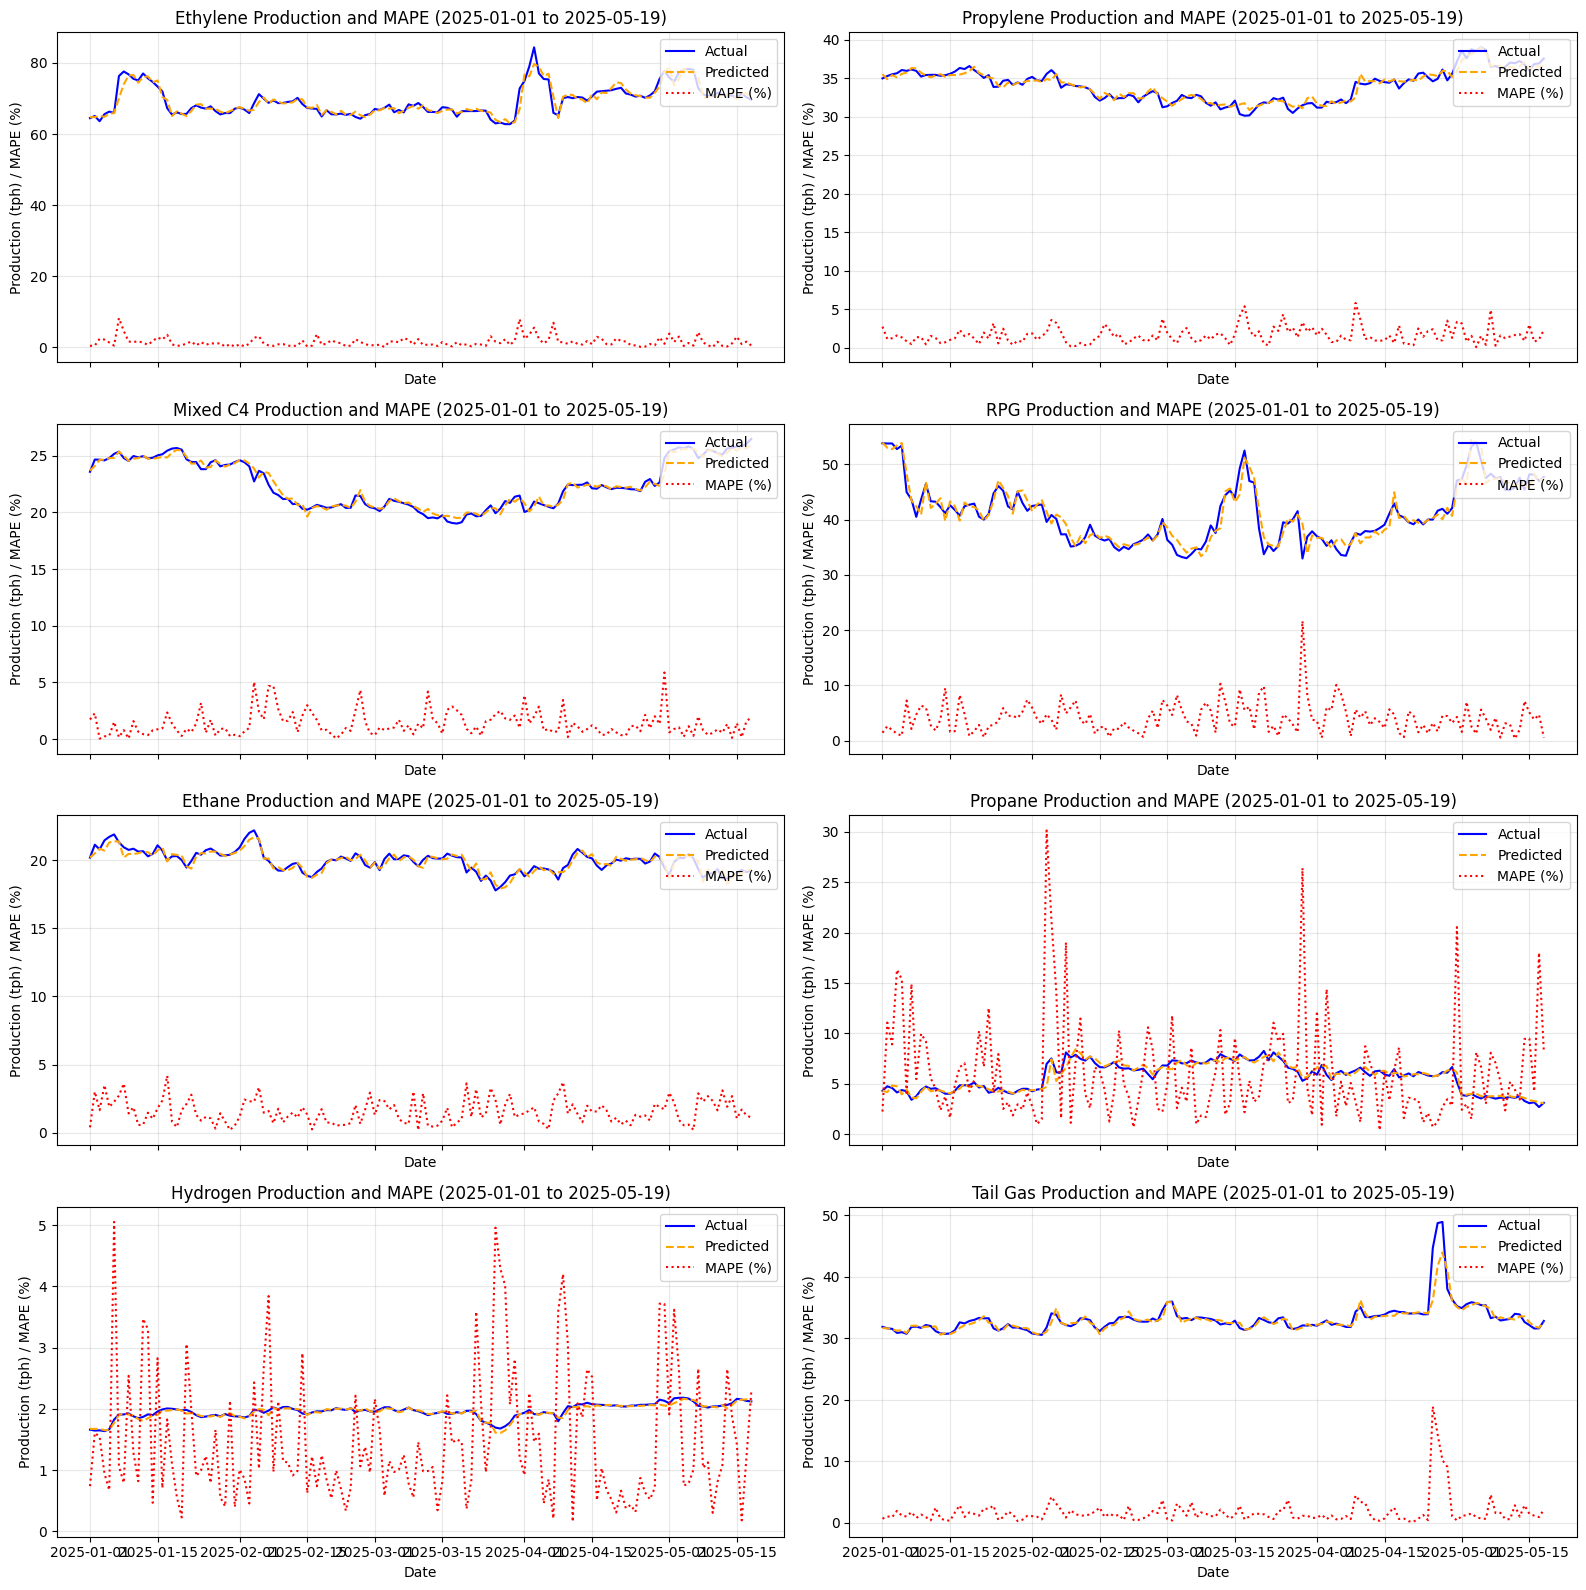

,Ethylene,Propylene,Mixed C4,RPG,Ethane,Propane,Hydrogen,Tail Gas
2025-05-15,3.023422,3.031250,1.416122,5.100031,1.046730,9.497360,1.421216,1.418116
2025-05-16,0.919852,0.810226,0.172059,3.809093,1.703647,4.234293,0.178807,1.119749
2025-05-17,1.612954,1.099674,1.627399,4.698095,1.277368,18.016832,1.220680,0.882703
2025-05-18,0.488461,2.340848,1.882217,0.551095,1.116451,8.169720,2.286947,2.092183
2025-05-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


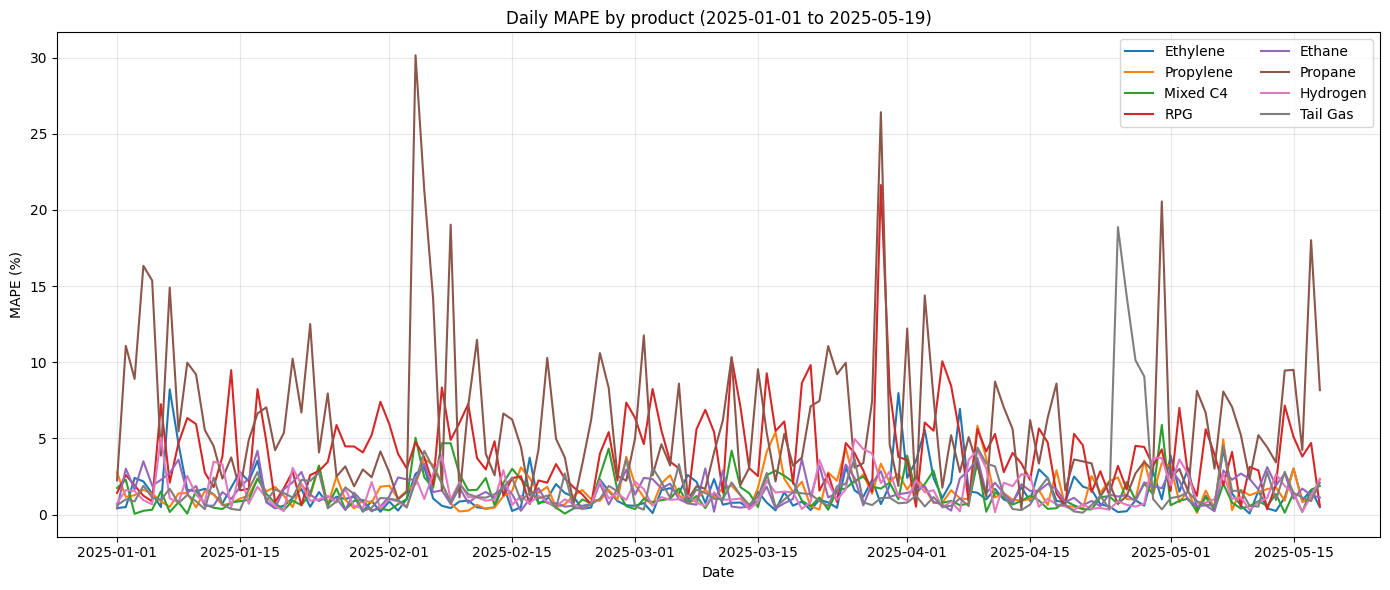

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

# Daily MAPE chart for 2025-01-01 through 2025-05-19

# --- Visualization: Daily MAPE chart ---\n",
mape_start = pd.Timestamp('2025-01-01')
mape_end = pd.Timestamp('2025-05-19')
eps = 1e-6,
pred_window = preds.loc[(preds.index >= mape_start) & (preds.index <= mape_end)].copy()
actual_window = (
    Y_12h.loc[pred_window.index, pred_window.columns]
)
daily_mape : dict[str,pd.Series]={}
daily_actual_production : dict[str,pd.Series]={}
daily_pred_production : dict[str,pd.Series]={}

for col in pred_window.columns:
    actual = actual_window[col].astype(float)
    pred_vals = pred_window[col].astype(float)
    valid_mask = actual.abs() > eps
    if valid_mask.any():
        rel_err = (pred_vals[valid_mask] - actual[valid_mask]).abs() / actual[valid_mask].abs()
        daily = rel_err.groupby(pred_window.index[valid_mask].normalize()).mean() * 100.0
    else:
        daily = pd.Series(dtype=float)
    daily_mape[col] = daily
    if actual.notna().any():
        daily_actual = actual.groupby(actual.index.normalize()).mean()
    else:
        daily_actual = pd.Series(dtype=float)
    if pred_vals.notna().any():
        daily_pred = pred_vals.groupby(pred_vals.index.normalize()).mean()
    else:
        daily_pred = pd.Series(dtype=float)
    daily_pred_production[col] = daily_pred
    daily_actual_production[col] = daily_actual

daily_mape_df = pd.DataFrame(daily_mape)
daily_actual_df = pd.DataFrame(daily_actual_production)
daily_pred_df = pd.DataFrame(daily_pred_production)
date_index = pd.date_range(start=mape_start, end=mape_end, freq='D')
daily_mape_df = daily_mape_df.reindex(date_index)
daily_actual_df = daily_actual_df.reindex(date_index)
daily_pred_df = daily_pred_df.reindex(date_index)

name_map = {
    'Ethylene_prod_t+1': 'Ethylene',
    'Propylene_prod_t+1': 'Propylene',
    'MixedC4_prod_t+1': 'Mixed C4',
    'RPG_prod_t+1': 'RPG',
    'Ethane_prod_t+1': 'Ethane',
    'Propane_prod_t+1': 'Propane',
    'Hydrogen_prod_t+1': 'Hydrogen',
    'Tail_Gas_prod_t+1': 'Tail Gas',
}
daily_mape_df = daily_mape_df.rename(columns=name_map)
daily_actual_df = daily_actual_df.rename(columns=name_map)
daily_pred_df = daily_pred_df.rename(columns=name_map)
products=daily_mape_df.columns.tolist()
n_products=len(products)
n_cols=2
n_rows=math.ceil(n_products/n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows), sharex=True)
axes=axes.flatten()
for ax, product in zip(axes, products):
    ax.plot(daily_actual_df.index, daily_actual_df[product], label='Actual', color='blue')
    ax.plot(daily_pred_df.index, daily_pred_df[product], label='Predicted', color='orange', linestyle='--')
    ax.plot(daily_mape_df.index, daily_mape_df[product], label='MAPE (%)', color='red', linestyle=':')
    ax.set_title(f'{product} Production and MAPE (2025-01-01 to 2025-05-19)')
    ax.set_ylabel('Production (tph) / MAPE (%)')
    ax.set_xlabel('Date')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
plt.tight_layout()
plt.show()



plt.figure(figsize=(14, 6))
for col in daily_mape_df.columns:
    plt.plot(daily_mape_df.index, daily_mape_df[col], label=col)
plt.title('Daily MAPE by product (2025-01-01 to 2025-05-19)')
plt.ylabel('MAPE (%)')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', ncol=2)
plt.tight_layout()
daily_mape_df.tail()
                                        


In [29]:
daily_mape_df.to_csv(OUT_DIR / "daily_mape_20250101_20250519.csv", index=True)
daily_actual_df.to_csv(OUT_DIR / "daily_production_20250101_20250519.csv", index=True)
daily_pred_df.to_csv(OUT_DIR / "daily_production_pred_20250101_20250519.csv", index=True)


PermissionError: [Errno 13] Permission denied: 'prod_out\\daily_production_pred_20250101_20250519.csv'

In [ ]:
# Example daily run for the whole horizon (or pass a shorter end date)
run_production(
gp, gps_dict, feature_cols_gp = run_production(
X_12h=X_12h, Y_12h=Y_12h,
merged_lims=merged_lims, pipeline=pipeline,
prices_df=prices_df,
total_spyro_yield_for_now=memo_spyro,
start=pd.Timestamp('2025-01-01'), end=pd.Timestamp('2025-05-19'),
mode='closed_loop',
closed_loop_opts=dict(
apply_timing='next_stamp',          # or 'next_stamp'
hold_policy='hold_until_next',    # step & hold
ml_train_mode='simulated',       # train ML on historical windows (fast/stable)
gp_train_mode='simulated',       # train GP on historical windows
cache_tag='_sim'                  # keep caches separate
    )))

In [34]:
# RCOT mass balance sensitivity for Naphtha and Gas furnaces\n",
ts_focus = X_12h.index.max()
row_focus = X_12h.loc[ts_focus].copy()
,
def _mass_balance_curve(row_base: pd.Series, rcot_values, setter, label: str) -> pd.DataFrame:
    rows = []
    for rc in rcot_values:
        row_adj = setter(row_base.copy(), rc)
        yields = opt.corrected_yields_for_row(
        row_adj,
        gps=gps_dict,
        feature_cols_gp=feature_cols_gp,
        total_spyro_yield_for_now=memo_spyro,
        spyro_ctx=None,
    )
    product_mass = sum(float(yields.get(f"{p}_prod_t+1", 0.0)) for p in PRODS_INTERNAL),
    feed_mass = sum(float(row_adj.get(f"Naphtha_chamber{i}", 0.0)) for i in range(1, 7)),
    feed_mass += sum(float(row_adj.get(f"Gas Feed_chamber{i}", 0.0)) for i in (4, 5, 6)),
    mass_balance = product_mass / feed_mass if feed_mass else np.nan
    rows.append({
    Furnace: label,
    RCOT: float(rc),
        product_mass_tph: product_mass,
        feed_mass_tph: feed_mass,
        mass_balance: mass_balance,
            })
    return pd.DataFrame(rows)
naph_range = np.arange(830.0, 853.0 + 1.0, 1.0)
gas_range = np.arange(860.0, 890.0 + 1.0, 1.0)
naph_curve = _mass_balance_curve(row_focus, naph_range, gpmod.rcot_setter_lf_naph, "Naphtha Furnace")
gas_curve = _mass_balance_curve(row_focus, gas_range, gpmod.rcot_setter_gf_gas, "Gas Furnace")
mass_balance_curves = pd.concat([naph_curve, gas_curve], ignore_index=True)
plt.figure(figsize=(10, 6))
for furnace, group in mass_balance_curves.groupby("Furnace"):
    plt.plot(group["RCOT"], group["mass_balance"], marker="o", label=furnace)
    plt.title(f"Mass Balance vs RCOT @ {ts_focus:%Y-%m-%d %H:%M}")
    plt.xlabel("RCOT (u00b0C)")
    plt.ylabel("Mass Balance (Product / Feed)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    mass_balance_curves.head()
mass_balance_curves.to_csv(OUT_DIR / f"mass_balance_curve_{ts_focus:%Y%m%d_%H%M}.csv", index=False)


NameError: name 'gps_dict' is not defined